# 1 Introduction

Diabetes is a growing problem in the US. According to the CDC, 34.2 million Americans have this disease. This amounts to 10.5% of the total US population. Of these, only 26.9 million Americans have been diagnosed, leaving 7.3 million diabetic Americans (21.4% of all diabetic Americans) undiagnosed. In addition to the health risks, the CDC estimates that between 2012 and 2017, the excess medical costs associated with diabetes increased from $\$ $8,417 to $\$ $9,601 per capita. Moreover, the trend for diabetes in the US continues to increase.

In light of the health risks that come from diabetes, it is of paramount importance to catch this disease as soon as possible. However, the cost of such a test ranges between $\$ $176 to $\$ $236. It thus becomes necessary to develop a model for predicting diabetes that both minimizes the number of false negatives (for health reasons) and false positives (for financial reasons) and also maximizes the number of true negatives (also for financial reasons).

These optimizations translate to maximizing both the recall and precision of our model. However, in this context, recall is much more important as a low recall score would mean that many people are not getting the medical attention they need.

# 2 Importing the Data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#import scoring methods
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import plot_tree

#import preprocessing methods
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [2]:
raw_df = pd.read_csv('Data/diabetes.csv')
raw_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


We can see that there are zeroes in many of the columns. Assuming that Glucose, BloodPressure, Insulin, BMI, DiabetesPedigreeFuction, and Age should be nonzero, we interpret these zeroes as missing data points.

# 3 Imputing the Missing Data

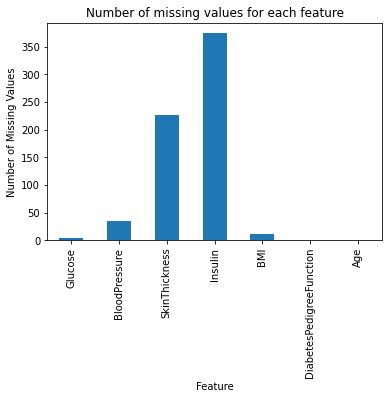

In [43]:
#compute the number of missing values for each feature and plot on a bar graph
((raw_df == 0).sum())[1:-1].plot.bar()

#create title and labels for plot
plt.title('Number of missing values for each feature')
plt.ylabel('Number of Missing Values')
plt.xlabel('Feature')
plt.show()

SkinThickness and Insulin have significant missing data.

Replace all zeroes in the columns for Glucose to Age with NaN. These missing values will pose a serious challenge for out prediction models, particularly for Insulin and SkinThickness. Therefore we will not use these two columns in our analysis and will instead use the others (Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction, and Age) with missing values imputed with the mean.

In [4]:
df = raw_df.copy()

#replace zeroes with np.nan
df[df.iloc[:, 1:7]==0] = np.nan

#fill missing values with the mean for that feature and delete
#columns corresponding to SkinThickness and Insulin
df = df[['Pregnancies', 'Glucose', 'BloodPressure',
         'BMI','DiabetesPedigreeFunction', 'Age', 'Outcome']].fillna(df.mean(axis=0))

In [5]:
#split the data into features and targets
X = df.iloc[:, :-1]
y = df['Outcome']

# 4 Data Visualization

## 4.1 Distribution of Outcomes

We take a look at how skewed the results for the diabetes results are:

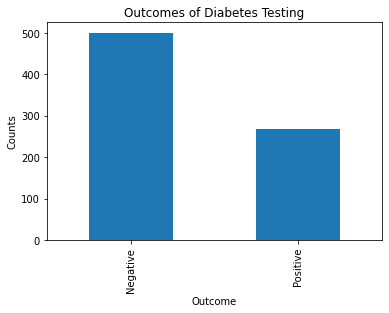

In [6]:
#count the number of positive and negative outcomes
D = df.Outcome.value_counts()
D.index = ['Negative', 'Positive']
D.plot.bar()

#create title and labels for graph
plt.xlabel('Outcome')
plt.ylabel('Counts')
plt.title("Outcomes of Diabetes Testing")
plt.show()

It is clear that, although the data is skewed towards negative results, it is not skewed in a significant way (approximately a 2:1 ratio).

## 4.2 Correlation Matrix


We now take a look at the correlations between the various features and target.

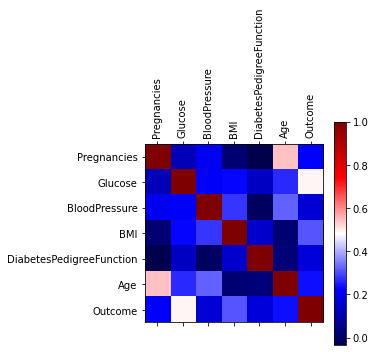

In [7]:
#compute the correlation matrix
data = df.corr()

#graph this matrix as a heatmap
plt.matshow(data, cmap="seismic")
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.yticks(range(len(df.columns)), df.columns)

plt.colorbar()
plt.show()

We see that there is high correlation between Glucose and Outcome and also between Pregnancies and Age. We take a look at the numbers for correlation with Outcome.

In [8]:
data.Outcome.sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64

The features with highest correlation with Outcome are Glucose and BMI.

## 4.3 Conditional Distributions of Features and Pairs of Features

We use seaborn to create scatter plots of pairs of features, color-coding by the Outcome. This allows us to inspect the distributions of pairs of variables for both diabetic and non-diabetic patients.

Here are some things that we should notice:
- The conditional distributions, conditioned on the Outcome, for Pregnancies, Glucose, and Age are noticably different for each value of Outcome.
- Many of the conditional distributions for non-diabetic patients are approximately normal or lognormal. For example, both Glucose and BloodPressure are very close to normal distributions for non-diabetic patients.
- The two conditional distributions for Glucose have significant non-overlap. This makes it a variable that is very useful in predicting diabetes as already shown by its high correlation (0.493) with Outcome.

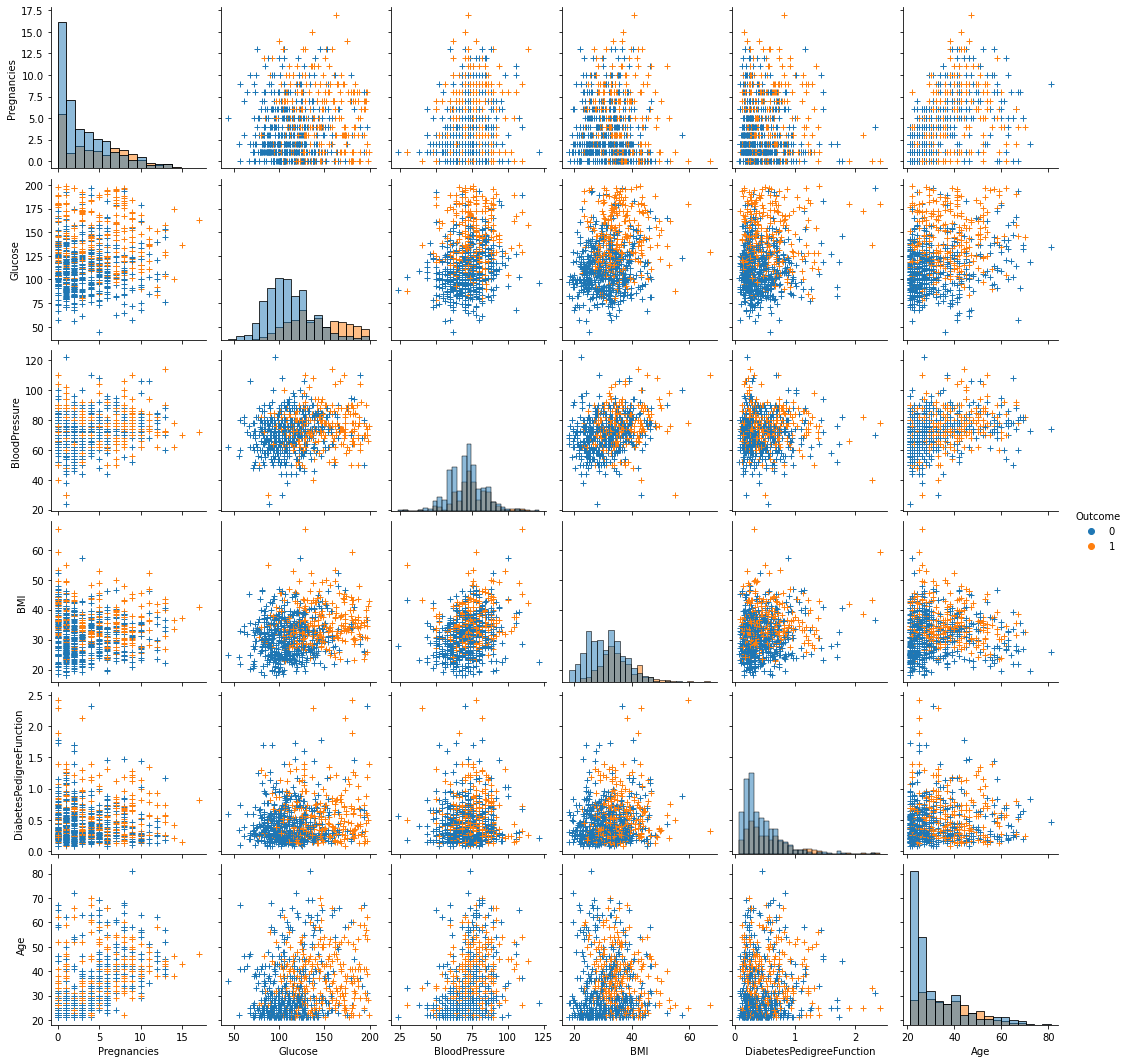

In [9]:
sb.pairplot(df,
            hue='Outcome',
            plot_kws=dict(marker="+", linewidth=1),
            diag_kind = 'hist')
plt.show()

We can take a closer look at some of the more prominent plots. We first consider Glucose versus BMI.

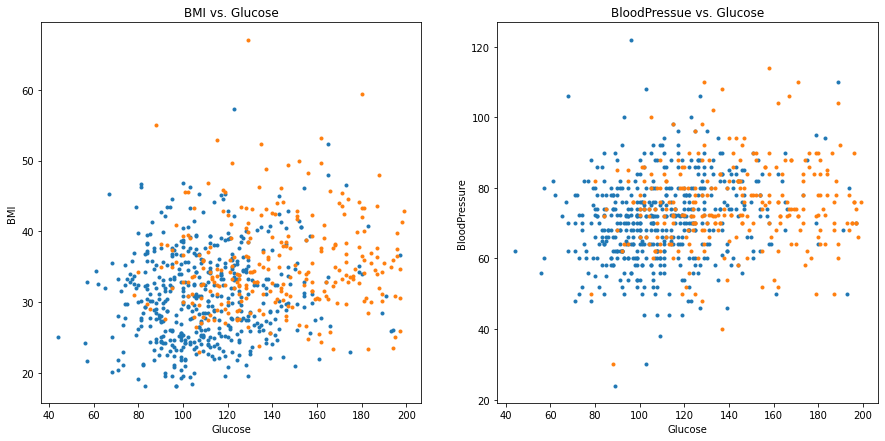

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))

#violin plot for Glucose
for i in range(2):
    ax1.scatter(df[df.Outcome==i].Glucose, df[df.Outcome==i].BMI, marker = '.')
ax1.set_title('BMI vs. Glucose')
ax1.set_xlabel('Glucose')
ax1.set_ylabel('BMI')

#violin plot for BMI
for i in range(2):
    ax2.scatter(df[df.Outcome==i].Glucose, df[df.Outcome==i].BloodPressure, marker = '.')
ax2.set_title('BloodPressue vs. Glucose')
ax2.set_xlabel('Glucose')
ax2.set_ylabel('BloodPressure')

plt.show()

It looks as if the pair of BMI and Glucose is approximately a joint normal distribution. This is helpful to know as it appears a logistic regression will be a good model, if we were only given Glucose and BMI.

The same can be said of Glucose and Blood Pressure: they are approximately a joint normal distribution with noticiable differences in the mean if separated by the Outcome.

To better understand the differences between the conditional distributions for each of the features, we can plot the normalized histograms: for each of the following plots, the blue and orange histograms each represent the frequencies for measures in a particular Outcome class.

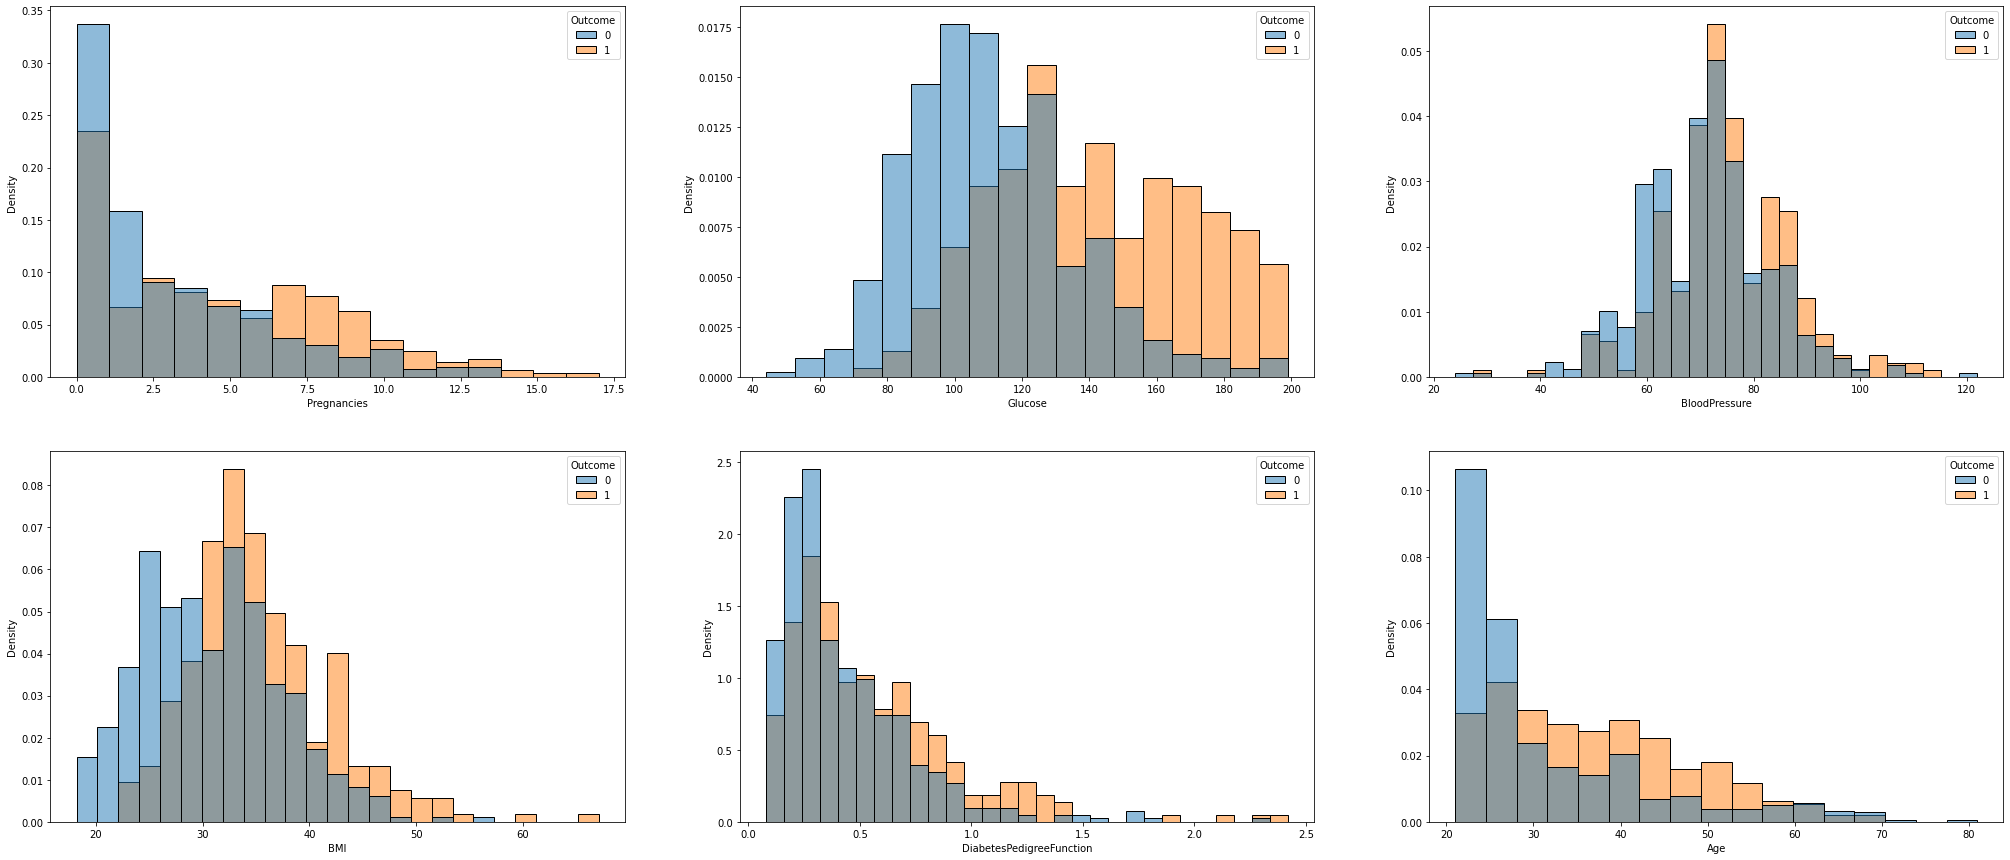

In [11]:
#plot histograms for each of the features based on outcome
fig, axs = plt.subplots(2, 3, figsize=(35,15))
for i in range(6):
    sb.histplot(df,
                x=df.columns[i],
                hue='Outcome',
                stat='density',
                common_norm=False,
                ax=axs[i//3][i%3])


Here, we have plotted the normalized histograms for each of the features, conditioned on Outcome. Here we have accentuated the differences in the distributions: it is now clear that the means for the distributions of each column are different.

## 4.4 Understanding the Differences between the Conditional Distributions.

Next, we take a look at the distributions for Glucose, BMI, and DiabetesPedigreeFunction (DPF) conditioned on outcome.

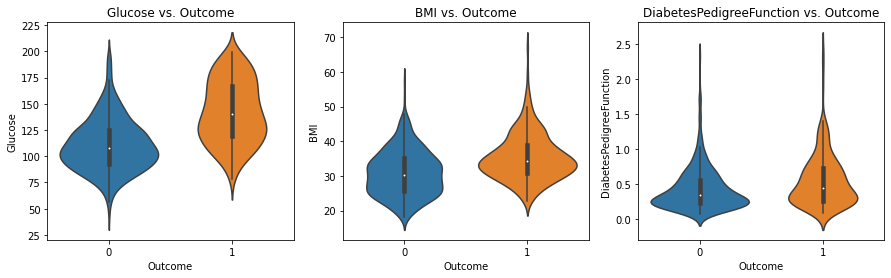

In [12]:
f, axs = plt.subplots(1, 3, figsize = (15,4))

i=0
for feat in ['Glucose', 'BMI', 'DiabetesPedigreeFunction']:
    sb.violinplot(x='Outcome', y=feat, data=df, ax=axs[i])
    axs[i].set_title(feat+' vs. Outcome')
    axs[i].set_xlabel('Outcome')
    axs[i].set_ylabel(feat)
    i += 1

Glucose levels are lower for patients without diabetes than those with diabetes. Furthermore, the glucose levels of patients without diabetes has a much lower variance than the glucose levels of patients with diabetes.

The same is true for BMI: in general, patients without diabetes have a higher BMI than those without diabetes. However, the standard deviation of the BMI for patients without diabetes is much higher than the BMI of patients with diabetes.

For the DiabetesPedigreeFunction, the relationship is much less pronounced. We will take a look at the numbers to discern a relationship.

In [13]:
df.groupby('Outcome')['DiabetesPedigreeFunction'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,500.0,0.429734,0.299085,0.078,0.22975,0.336,0.56175,2.329
1,268.0,0.550500,0.372354,0.088,0.26250,0.449,0.72800,2.420


The mean DPF for those with diabetes (0.5505) is higher than the mean DPF for those without diabetes (0.4297). This makes sense as diabetes has a genetic factor and the DPF is relates family history to the likelihood that diabetes will affect an individual.

Also notice that, for patients without diabetes, there are many more outliers than those with diabetes. However, this is most likely caused exacerbated by the skewedness of the test results.

We also found that the PDF had one of the weakest correlations with the Outcome (0.1738).

# 6 Data Analysis and Predictions

We scale the feature data to have mean 0 and standard deviation 1. Then, we split the data into training (67\%) and test (33%) sets.

In [14]:
scl = StandardScaler().fit(X)
X_scaled = scl.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

## 6.1 Scoring Functions

We first write a function that calculates and prints the confusion matrix of any given model and returns the recall, precision and accuracy scores in a dictionary.

As a reminder, the confusion matrix is given by
$$
C = 
\left(
\begin{array}{cc}
    \text{True Negatives} && \text{False Positives}\\
    \text{False Negatives} && \text{True Positives}
\end{array}
\right)
=\left(
\begin{array}{cc}
    TN && FP\\
    FN && TP
\end{array}
\right)
$$

We also have
$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{All Predictions}} = \frac{TP + TN}{TP+FP+TN+FN}
$$
and
$$
\text{Recall} = \frac{\text{True Positives}}{\text{Actual Positives}} = \frac{TP}{TP+FN}
$$
and
$$
\text{Precision} = \frac{\text{True Positives}}{\text{Predicted Positives}} = \frac{TP}{TP+FP}.
$$

In [96]:

def confusion_matrix_scores(model, X_train_data, y_train_data, X_test_data, y_test_data):
    '''Calculates the precision and recall scores for both the training and test set for the model.
    Also plots the confusion matrix.'''
    
    #fit model
    fitted_model=model.fit(X_train_data, y_train_data)
    
    #use the trained model to make predictions
    train_prediction = fitted_model.predict(X_train_data)
    test_prediction = fitted_model.predict(X_test_data)
    
    #metrics for the train set
    train_recall = recall_score(y_train_data, train_prediction)
    train_precision = precision_score(y_train_data, train_prediction)
    train_accuracy = accuracy_score(y_train_data, train_prediction)
    d_train={'Training set precision_score': train_precision,
             'Training set recall_score': train_recall,
             'Training set accuracy_score': train_accuracy}
    
    #metrics for the test set
    test_recall = recall_score(y_test_data, test_prediction)
    test_precision = precision_score(y_test_data, test_prediction)
    test_accuracy = accuracy_score(y_test_data, test_prediction)
    d_test={'Test set precision_score': test_precision,
            'Test set recall_score': test_recall,
            'Test set accuracy_score': test_accuracy}
    
    #confussion matrices of training and test sets
    confusion_matrix_train = confusion_matrix(y_train_data, train_prediction)
    confusion_matrix_test = confusion_matrix(y_test_data, test_prediction)

    #combine the two results 
    d={**d_train, **d_test}
    result = pd.Series(d)
    
    #plot heat maps of confusion matrices
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4))

    ax1=sb.heatmap(confusion_matrix_train, annot=True, fmt='d', ax=ax1, cmap='Accent') 
    ax1.set_title('Confusion matrix for training set')
    ax1.set_xlabel('Predicted class')
    ax1.set_ylabel('True class')

    sb.heatmap(confusion_matrix_test, annot=True, fmt='d', ax=ax2, cmap='Accent')
    ax2.set_title('Confusion matrix for test set')
    ax2.set_xlabel('Predicted class')
    ax2.set_ylabel('True class')

    plt.show()
    print(result)

We also write two functions that makes it easier to plot the scores for a given model for a range of parameter values. For instance, the following function can be used with the $k$-nearest neighbor model to plot the scores, recalls, and precisions for different values of $k$.

In [16]:
def score_classifier(model, X_train_data, y_train_data, X_test_data, y_test_data, results):
    '''Calculate the test scores for model and append to dictionary results.'''
    model.fit(X_train_data, y_train_data)
    test_prediction = model.predict(X_test_data)
    
    #calculate scores
    recall = recall_score(y_test_data, test_prediction)
    precision = precision_score(y_test_data, test_prediction)
    accuracy = accuracy_score(y_test_data, test_prediction)
    
    #append to dictionary
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)

def plot_scores_by_parameters(results, parameter, m=2, M=50, step=1, fs=(30,30)):
    '''Plot the contents of results.
       results will be a dictionary with keys Accuracy, Recall and Precision.'''
    fig, axs = plt.subplots(figsize=fs)
    
    #plot results
    plt.plot(np.arange(m,M,step), results["Accuracy"], marker = '.', label='Accuracy')
    plt.plot(np.arange(m,M,step), results["Recall"], marker = '.', label='Recall')
    plt.plot(np.arange(m,M,step), results["Precision"], marker = '.', label='Precision')

    plt.xlabel(parameter)
    plt.ylabel("Precision/Recall/Accuracy")
    plt.title("Scores vs "+parameter)
    plt.legend()

    plt.show()

The models that we will use are listed as follows:

1. Decision Tree Classifier    
2. Gaussian Naive Bayes Classifier
3. Logistic Regression
4. K-Nearest Neighbors Classifier
5. Support Vector Classifier
    
We will discuss each of these separately.

## 6.2 Decision Tree Classifier

### 6.2.1 Description

A Decision Tree Classifier (DTC) seeks to classify data points based on conditions which its features satisfy. That is, a DTC can be represented as a tree where, starting at the root node, questions about a specific feature are asked and the answer determines which child node to consider next. There are many such trees, however algorithms seeking to model data using a decision tree minimize either the entropy of the tree or the gini index of the tree, both of which are measures for the information gained at each level of the tree.

### 6.2.2 Tuning the hyperparameters

We can find the optimal hyperparameters by performing a grid search. The hyperparameters that we wish to optimize are:

   * Criterion: create the tree by minimizing the gini index or the entropy of the tree.
   * Maximum Depth: the maximum depth of the tree.
   * Minimum Samples for Leaves: the minimum samples allowed for a single leaf.
   * Weights: relative weights for the two classes.

In [53]:
#the set of hyperparameters that we will tune
weights = [{1:1,0:1}, {1:2,0:1}, {1:1,0:2}]
param_grid = {
                'criterion'              : ['gini','entropy'],
                'max_depth'              : np.arange(2,10),
                'min_samples_leaf'       : np.arange(1,20),
                'class_weight'           : weights
}

#initiate the GridSearch with 5-fold cross validation
tree_model = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='recall')

#fit the GridSearch to the training set
grid_search.fit(X_train, y_train)

#print the best parameters
print("Best Paramerers:\n\n", pd.Series(grid_search.best_params_))

Best Paramerers:

 class_weight        {1: 2, 0: 1}
criterion                entropy
max_depth                      3
min_samples_leaf               4
dtype: object


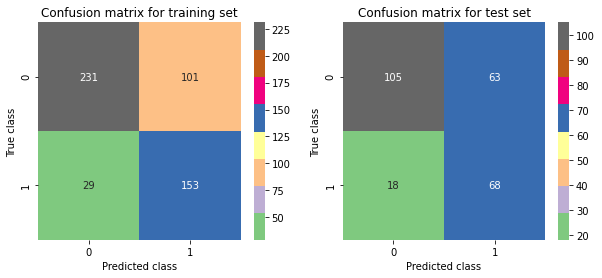

Training set precision_score    0.602362
Training set recall_score       0.840659
Training set accuracy_score     0.747082
Test set precision_score        0.519084
Test set recall_score           0.790698
Test set accuracy_score         0.681102
dtype: float64


In [97]:
dtc_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=4, class_weight={1:2,0:1})
confusion_matrix_scores(dtc_clf, X_train, y_train, X_test, y_test)

Note that the optimal parameters classifies 123 of the 254 test patients as nondiabetic. The precision score on the test set is 51.2% so that only a little over a half of all predicted positives are true positives. This model also misses about a fifth of all true positives, classifying them as nondiabetic.

In [56]:
pd.DataFrame(cross_validate(dtc_clf, X_scaled, y, cv=10,
                            scoring = ('accuracy', 'recall', 'precision'))).mean(axis=0)[2:]

test_accuracy     0.703093
test_recall       0.850855
test_precision    0.549583
dtype: float64

Using cross-validation, we see that all three scores actually increase (on average). This tells us that this model is not over fitting and is quite generalizable.

## 6.3 Gaussian Naive Bayes Classifier

### Description

The Gaussian Naive Bayes (NB) Classifier looks to classify a data point given by $(x_1,\dots, x_N)$ into one of $K$ categories, denoted $C_k$ $k=1,\dots, K$. The main assumption here is that each of the features $x_i$ are independent and normally distributed. The mean and standard deviation are estimated using the training data. Then, Bayes' Theorem is used to compare the probabilities that such a data point is classified into each class $C_k$.

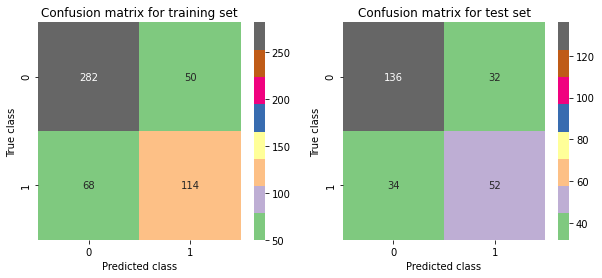

Training set precision_score    0.695122
Training set recall_score       0.626374
Training set accuracy_score     0.770428
Test set precision_score        0.619048
Test set recall_score           0.604651
Test set accuracy_score         0.740157
dtype: float64


In [98]:
gnb_clf = GaussianNB()
confusion_matrix_scores(gnb_clf, X_train, y_train, X_test, y_test)

In [110]:
pd.DataFrame(cross_validate(gnb_clf, X_scaled, y, cv=10,
                   scoring = ('precision', 'recall', 'accuracy'))).mean(axis=0)[2:]

test_precision    0.531440
test_recall       0.907123
test_accuracy     0.687491
dtype: float64

This model does not do much in terms of putting more importance on the recall score. We can optimize the prior hyperparameter using a grid search.

In [73]:
#the set of hyperparameters that we will tune
weights = [[1-i, i] for i in np.arange(0.1,0.8,0.02)]
param_grid = {'priors' : weights}

#initiate the GridSearch with 5-fold cross validation
nb_model = GaussianNB()
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='recall')

#fit the GridSearch to the training set
grid_search.fit(X_train, y_train)

#print the best parameters
print("Best Paramerers:\n\n", pd.Series(grid_search.best_params_))

Best Paramerers:

 priors    [0.21999999999999986, 0.7800000000000001]
dtype: object


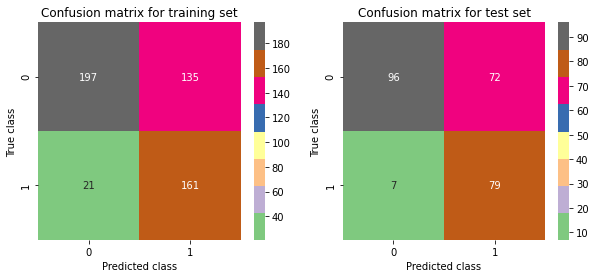

Training set precision_score    0.543919
Training set recall_score       0.884615
Training set accuracy_score     0.696498
Test set precision_score        0.523179
Test set recall_score           0.918605
Test set accuracy_score         0.688976
dtype: float64


In [99]:
gnb_clf = GaussianNB(priors=[0.22, 0.78])
confusion_matrix_scores(gnb_clf, X_train, y_train, X_test, y_test)

Since the training scores and test scores are on par, we see that we are not overfitting the training set too much. In fact the recall score for the test set is greater than that of the training set.

In [109]:
pd.DataFrame(cross_validate(gnb_clf, X_scaled, y, cv=10,
                   scoring = ('precision', 'recall', 'accuracy'))).mean(axis=0)[2:]

test_precision    0.531440
test_recall       0.907123
test_accuracy     0.687491
dtype: float64

Comparing this performance with the decision tree classifier, we see that the accuracy and precision scores are very close, but the naive bayes classifier outperforms the decision tree in the recall score.

## 6.4 Logistic Regression

### 6.4.1 Description
Logistic regression seeks to classify data into binary categories, say $C_0$ and $C_1$, by associating the value of $y=0$ to the class $C_0$ and the value $y=1$ to the class $C_1$ and fitting a curve, with parameters $\pmb{\theta}$ and $\theta_0$, of the form
$$
    y = \frac{1}{1-e^{-\pmb{\theta}^T\mathbf{x}-\theta_0}}.
$$
The value of $y$ can be interpreted as giving the probability $P(C_1|\mathbf{x})$ that a data point $\mathbf{x}$ lies within class $C_1$.

### 6.4.2 Tuning the Threshold
By default, a data point $\mathbf{x}$ is classified into $C_1$ if $P(C_1|\mathbf{x}) > 0.5$ and $C_0$ otherwise.

If this threshold value $\alpha = 0.5$ is varied, then a data point $\mathbf{x}$ will be more likely or less likely to be classified into class $C_1$. For diabetes prediction, a question concerning health, if $P(C_1|\mathbf{x})$ is slightly less than 0.5, say 0.45, then it would be a good choice for a patient to take a more precise test to determine if a patient has diabetes.

For each threshold value $\alpha$, we plot the accuracy, recall, and precision scores for the logistic regression.

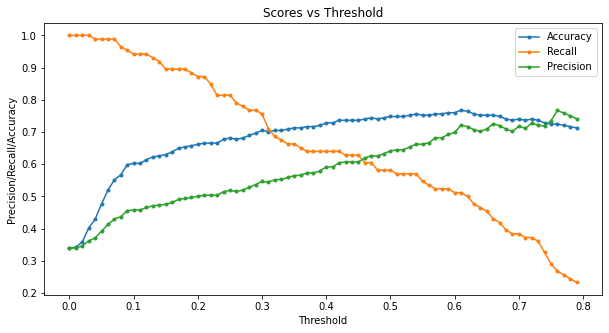

In [83]:
m, M, step = 0, 0.8, 0.01
LogReg_results = {"Accuracy" : [], "Recall" : [], "Precision" : []}

for i in np.arange(m, M, step):
    lreg = LogisticRegression(penalty='l2', class_weight={0:i, 1:1-i})
    score_classifier(lreg, X_train, y_train, X_test, y_test, LogReg_results)
plot_scores_by_parameters(LogReg_results, 'Threshold', m, M, step, (10,5))

Note that as $\alpha$ increases from 0 to 1, a patient is less likely to be classified as having diabetes, hence the recall decreases. Likewise, as $\alpha$ increases, the accuracy and precision tend to increase.

The recall score decreases sharply as $\alpha$ increases, while the accuracy and precision increase relatively slowly after $\alpha=$0.1.

### 6.4.3 Matthews Correlation Coefficient

Another measure of the quality of a model is the Matthews Correlation Coefficient (MCC). This is defined to be
$$
MCC = \frac{TP\cdot TN - FP\cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FN)(TN+FP)}}
$$

The MCC returns a value between -1 and 1. A value of $MCC=1$ is perfect prediction and $MCC=0$ indicates that the model is no better than random.

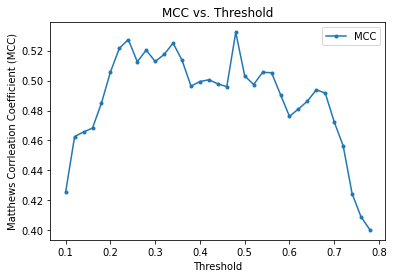

In [84]:
LogReg_MCC = []
m, M, step = 0.1, 0.8, 0.02

for i in np.arange(m,M,step):
    lreg = LogisticRegression(penalty='l2', class_weight={0:i, 1:1-i})
    lreg.fit(X_train, y_train)
    y_pred = lreg.predict(X_train)
    LogReg_MCC.append(matthews_corrcoef(y_pred, y_train))
    
plt.plot(np.arange(m,M,step), LogReg_MCC, marker = '.', label='MCC')

plt.xlabel("Threshold")
plt.ylabel("Matthews Corrleation Coefficient (MCC)")
plt.title("MCC vs. Threshold")
plt.legend()

plt.show()

We see a local maximum in the Matthews Correlation Coefficient around $\alpha=$ 0.25.

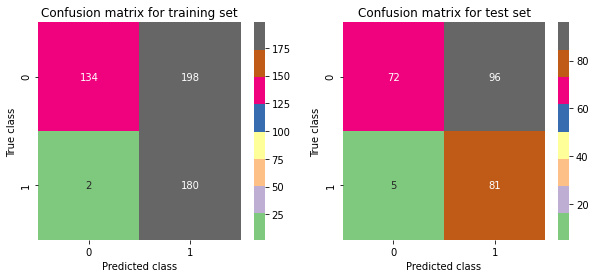

Training set precision_score    0.476190
Training set recall_score       0.989011
Training set accuracy_score     0.610895
Test set precision_score        0.457627
Test set recall_score           0.941860
Test set accuracy_score         0.602362
dtype: float64


In [100]:
lreg = LogisticRegression(penalty='l2', class_weight={0:0.1, 1:0.9})
confusion_matrix_scores(lreg, X_train, y_train, X_test, y_test)

In [108]:
pd.DataFrame(cross_validate(lreg, X_scaled, y, cv=10,
                            scoring = ('precision', 'recall', 'accuracy'))).mean(axis=0)[2:]

test_precision    0.459912
test_recall       0.985185
test_accuracy     0.589781
dtype: float64

Precision is incredibly low, but the recall is extremely high. Since the average recall for cross-validation is much higher than the recall of the test set, we can conclude that this hyperparameter choice does not overfit the test set.

## 6.5 K-Nearest Neighbors Classifier

### 6.5.1 Description

The $k$-Nearest Neighbors (KNN) Classifier is an algorithm with a single integer parameter $k\ge 1$.

Given $k\ge 1$ and training data $x_1,\dots, x_N\in\mathbb{R}^d$, that is, there are $d$ features for the data and $N$ sample points, along with labels $y_1,\dots, y_N$ for each of the $N$ sample points, we wish to make a prediction about a new data point $x_{new}$. The KNN algorithm does this by calculating the distance from $x_{new}$ to each of the points $x_i$, $i=1,\dots, N$, and classifies the point $x_{new}$ into the class given by majority vote of the $k$ points $x_i$ which are closest to $x_{new}$.

There are a few concerns that need to be addressed:

1. What distance metric should be used? Typically the Euclidean $L^2$ metric is used, but there are many other options, such as the Manhattan metric ($L^1$) or the $L^\infty$ metric.
2. The feature data must be scaled to ensure that all features carry the same weight when calculating distance. For instance, if one feature has a small variance while another had a relatively large variance, then the first feature would not contribute much to calculating the distance and so would be relatively ignored in KNN.

### 6.5.2 Varying the number of neighbors

To address these concerns, we will be scaling the feature data of both the training and test set so that each feature has mean 0 and standard deviation 1. As for the distance to be used, we will use the standard Euclidean metric.

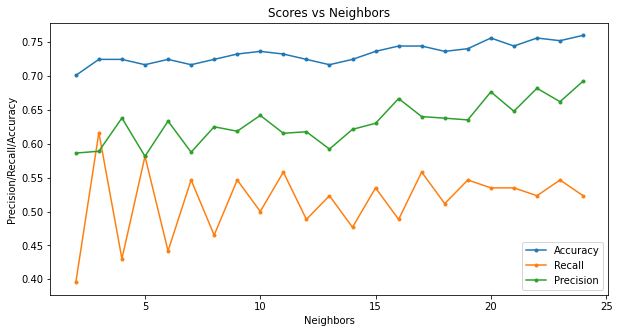

In [26]:
m, M, step = 2, 25, 1
KNN_results = {"Accuracy" : [], "Recall" : [], "Precision" : []}

for i in np.arange(m, M, step):
    knn_clf = KNeighborsClassifier(n_neighbors=i)
    score_classifier(knn_clf, X_train, y_train, X_test, y_test, KNN_results)
plot_scores_by_parameters(KNN_results, 'Neighbors', m, M, step, (10,5))

An examination of the plot shows that the recall is maximized at $k=3$.

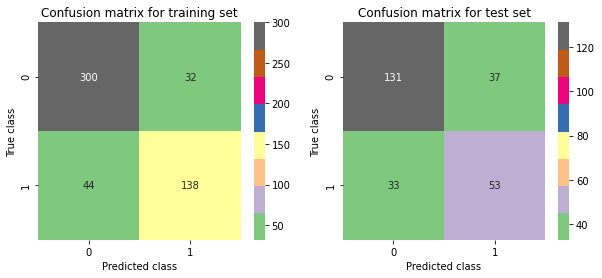

Training set precision_score    0.811765
Training set recall_score       0.758242
Training set accuracy_score     0.852140
Test set precision_score        0.588889
Test set recall_score           0.616279
Test set accuracy_score         0.724409
dtype: float64


In [101]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
confusion_matrix_scores(knn_clf, X_train, y_train, X_test, y_test)

In [107]:
pd.DataFrame(cross_validate(knn_clf, X_scaled, y, cv=10,
                            scoring = ('precision', 'recall', 'accuracy'))).mean(axis=0)[2:]

test_precision    0.634348
test_recall       0.563818
test_accuracy     0.731835
dtype: float64

This recall score is fairly low. Comparing the training and test scores, it seems that this model overfits the training data.

## 6.6 Support Vector Classifier

### 6.6.1 Description

Support Vector Classifiers (SVC) seek to divide a set of data into two classes by via a line. A loss function is defined by penalizing an incorrect classification by an amount proportional to the data point's distance to the line, SVC seeks to minimize this loss function.

Just as with logistic regression, a binary SVC has a hyperparameter in the form of the relative weights of its two classes. We can plot the precision, recall, and accuracy for each value of this hyperparameter $\alpha$ between 0 and 1 to obtain the following plot.

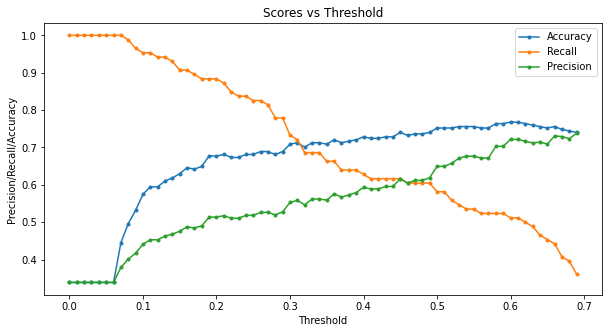

In [102]:
m, M, step = 0, 0.7, 0.01
SVC_results = {"Accuracy" : [], "Recall" : [], "Precision" : []}

for i in np.arange(m, M, step):
    svc_clf = SVC(kernel='linear', class_weight={0:i, 1:1-i})
    score_classifier(svc_clf, X_train, y_train, X_test, y_test, SVC_results)
plot_scores_by_parameters(SVC_results, 'Threshold', m, M, step, (10,5))

The accuracy seems to level off around a threshold of $\alpha=$ 0.2, while the precision continuouly increases and the recall begins to decrease sharply at this point.

### 6.6.2 Matthews Correlation Coefficient

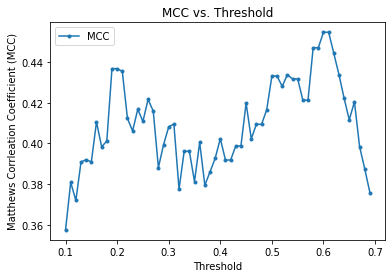

In [103]:
SVC_MCC = []
m, M, step = 0.1, 0.7, 0.01

for i in np.arange(m,M,step):
    svcreg = SVC(kernel='linear', class_weight={0:i, 1:1-i})
    svcreg.fit(X_train, y_train)
    y_pred = svcreg.predict(X_test)
    SVC_MCC.append(matthews_corrcoef(y_test, y_pred))
    
plt.plot(np.arange(m,M,step), SVC_MCC, marker = '.', label='MCC')

plt.xlabel("Threshold")
plt.ylabel("Matthews Corrleation Coefficient (MCC)")
plt.title("MCC vs. Threshold")
plt.legend()

plt.show()

There is an absolute maximum of the MCC at a threshold of 0.6, but this value yields a very low recall score. There is also a local maximum at a threshold of approximately 0.2.

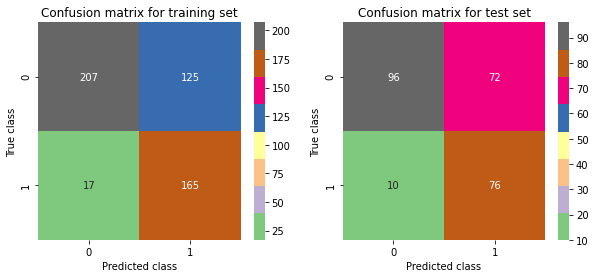

Training set precision_score    0.568966
Training set recall_score       0.906593
Training set accuracy_score     0.723735
Test set precision_score        0.513514
Test set recall_score           0.883721
Test set accuracy_score         0.677165
dtype: float64


In [104]:
svc_clf = SVC(kernel='linear', class_weight={0:0.2, 1:0.8})
confusion_matrix_scores(svc_clf, X_train, y_train, X_test, y_test)

In [106]:
pd.DataFrame(cross_validate(knn_clf, X_scaled, y, cv=10,
                            scoring = ('precision', 'recall', 'accuracy'))).mean(axis=0)[2:]

test_precision    0.634348
test_recall       0.563818
test_accuracy     0.731835
dtype: float64

Unfortunately, cross-validation yields a much lower recall score than the test set. We conclude that the hyperparameter $\alpha=$ 0.2 overfits the test set.

## 6.8 Conclusion

We now consider the scores for each of the 5 models described above, using cross-validation.

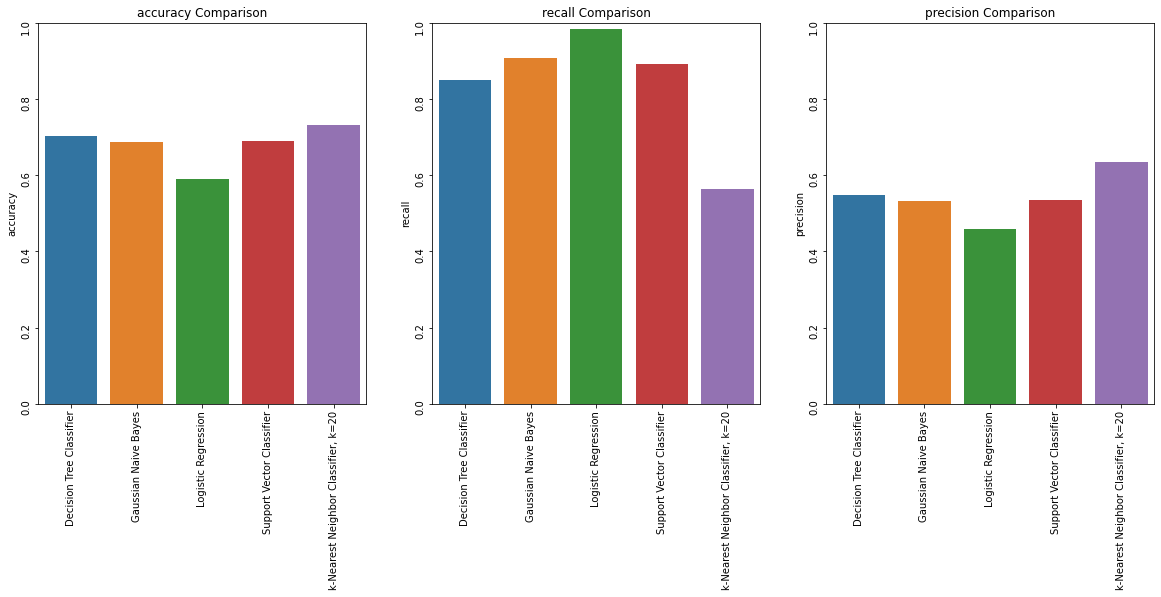

In [111]:
models = [('Decision Tree Classifier', dtc_clf),
         ('Gaussian Naive Bayes', gnb_clf),
         ('Logistic Regression', lreg),
         ('Support Vector Classifier', svc_clf),
         ('k-Nearest Neighbor Classifier, k=20', knn_clf)]
x = []
res = {'accuracy': [], 'recall': [], 'precision': []}

for name, model in models:
    x.append(name)
    cv_scores = cross_validate(model, X_scaled, y, cv=10, scoring = ('accuracy', 'recall', 'precision'))
    for key in ['accuracy', 'recall', 'precision']:
        res[key].append(cv_scores['test_'+key].mean())

res = pd.DataFrame(res, index=x)

fig, axs = plt.subplots(ncols=3, figsize=(20,7))
i=0
for col in res.columns:
    axs[i].tick_params(labelrotation=90)
    axs[i].set_title(res.columns[i] + " Comparison")
    axs[i].set_ylim((0,1.0))
    sb.barplot(x=res.index, y=col, data=res, ax=axs[i])
    i += 1

We see that the accuracy and precision scores are all similar, with Logistic Regression being the lowest in both categories. However, Logistic Regression has the highest recall score of all the models, being nearly 1.0.

The $k$-Nearest Neighbor Classifier does not perform well in recall and only does somewhat better than the others in the other two scores.